In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import scipy.stats as stats
from scipy.stats import chi2_contingency

from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.svm import SVR, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import Perceptron
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

from functools import reduce
from imblearn.over_sampling import SMOTE
import itertools
import copy
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') 


In [3]:
df0 = pd.read_csv('Depression Project Part 1.csv')

In [4]:
# set SEQN to index of the df0
df0.set_index('SEQN', inplace=True)      

df = df0.copy(deep=True)
print(df.columns.values)
df.head()

['mental illness' 'gender' 'age' 'race' 'family income' 'education'
 'marital status' 'military' 'HH food security' 'home type'
 'home ownership' 'health conditions' 'health compared to a year ago'
 'visit to mental pro' '#times received healthcare/yr' 'Employment status'
 'weekly work hrs' 'cur height(in)' 'cur weight(lb)' 'weight goal'
 'past weight(-1yr)(lb)' 'sm 100 cig?' 'cur sm status' 'sm daily freq'
 'sm monthly freq' 'quit sm num' 'quit sm unit' 'sm yrs'
 'nicotine content' 'freq:12 drinks/yr?' 'alco_freq_num' 'alco_freq_cat'
 'ever use cocaine' 'activity level' 'monthly activity freq'
 'activity duration' 'Serum folate(ng/ml)' 'serum VB12(pg/ml)'
 'diabetes status' 'pain (last yr)' 'prescr. medicine']


,mental illness,gender,age,race,family income,education,marital status,military,HH food security,home type,...,alco_freq_cat,ever use cocaine,activity level,monthly activity freq,activity duration,Serum folate(ng/ml),serum VB12(pg/ml),diabetes status,pain (last yr),prescr. medicine
SEQN,,,,,,,,,,,,,,,,,,,,,
12.0,0,1.0,37.0,3.0,11.0,3.0,1.0,1.0,1.0,2.0,...,2.0,1.0,1.0,4.0,90.0,23.0,730.0,2.0,2.0,1.0
20.0,0,2.0,23.0,1.0,6.0,1.0,1.0,2.0,1.0,4.0,...,1.0,1.0,1.0,1.0,30.0,19.9,260.0,2.0,1.0,2.0
34.0,1,2.0,38.0,4.0,5.0,2.0,1.0,2.0,3.0,1.0,...,1.0,1.0,1.0,30.0,30.0,8.4,1218.0,2.0,1.0,2.0
66.0,0,1.0,37.0,1.0,6.0,3.0,5.0,2.0,1.0,2.0,...,3.0,2.0,2.0,15.0,20.0,12.1,498.0,2.0,2.0,2.0
69.0,0,1.0,27.0,4.0,5.0,3.0,5.0,2.0,2.0,4.0,...,1.0,2.0,1.0,9.4,15.0,6.0,661.0,2.0,2.0,2.0


* Three types of variables:
    - Numerical
    - Categorical
    - Ordinal: low/med/high 
* Feature engineering:
    1. Feature transformation: 
        * Scaling: Standardization (part 3 train set)
        * Handle skewed distribution: log, sqrt
        * Binning 
    2. Feature creation
        * Dummy


# 1. Feature reduction - Manual grouping

### 1.1: 'cur height(in)', 'cur weight(lb)', 'past weight(-1yr)(lb)', 'weight goal' -> BMI, weight goal realized
1. Group 'cur height(in)' and 'cur weight(lb)' into BMI
        BMI = weight(lb)/(height(in)^2)*703
2. Group 'cur weight(lb)' and 'past weight(-1yr)(lb)' into weight change: change of weight from last year to this year
        weight change = (cur weight)/(past weight)
        weight change > 1: weight gain
        weight change < 1: weight loss
        * use ratio instead of (cur weight) - (past weight) to avoid negative values
3. Categorize 'weight change' from step 2 into a 3 values variables: see table in step 4

4. Group weight change obtained from previous step and weight goal into weight_goal_outcome: what's the goalion of the weight and what's the actual resulting weight change? 

| weight goal               | weight change                 |
|---------------------------|-------------------------------|
| 1 - want to gain          | 1 - gain: > 1.1               |
| 2 - want to lose          | 2 - loss: < 0.9               |
| 3 - want to stay the same | 3 - about the same: 0.9 ~ 1.1 |

* For this new variable 'weight_goal_outcome': 
    * 1 means Yes - successfully achieve weight goal & goal matches with actual result; goal = change
    * 2 means NO - fails to achieve weight goal 

| (weight goal, weight change) code   | weight_goal_change code |
|-------------------------------------|---------------------------|
| 1,1                                 | 1                         |
| 1,2                                 | 2                         |
| 1,3                                 | 2                         |
| 2,1                                 | 1                         |
| 2,2                                 | 2                         |
| 2,3                                 | 2                         |
| 3,1                                 | 2                         |
| 3,2                                 | 2                         |
| 3,3                                 | 1                         |

In [5]:
# step 1. Group 'cur height(in)' and 'cur weight(lb)' into BMI
df['BMI'] = df['cur weight(lb)']/((df['cur height(in)'])**2) * 703

# step 2. Create weight change variable from cur weight & past weight
df['weight change'] = df['cur weight(lb)']/df['past weight(-1yr)(lb)']

# step 3. Categorize 'weight change category'('wcc') from step 2 into a 3 values variables
df['weight change(category)'] = 0
df['weight change(category)'][df['weight change'] > 1.1] = 1 # weight gain
df['weight change(category)'][df['weight change'] < 0.9] = 2 # weight loss
df['weight change(category)'][(df['weight change'] >= 0.9) & (df['weight change'] <= 1.1)] = 3 # weight stays the same

# step 4. Create weight_goal_realized based on weight change(category) and weight goal
df['weight goal realized'] = 0 # initialize the col with 0 
df['weight goal realized'][df['weight change(category)'] == df['weight goal'] ] = 1 # change to 1 if find matches

df = df.drop(['cur height(in)','cur weight(lb)','past weight(-1yr)(lb)','weight change','weight change(category)','weight goal'], axis=1)
df.head()

,mental illness,gender,age,race,family income,education,marital status,military,HH food security,home type,...,activity level,monthly activity freq,activity duration,Serum folate(ng/ml),serum VB12(pg/ml),diabetes status,pain (last yr),prescr. medicine,BMI,weight goal realized
SEQN,,,,,,,,,,,,,,,,,,,,,
12.0,0,1.0,37.0,3.0,11.0,3.0,1.0,1.0,1.0,2.0,...,1.0,4.0,90.0,23.0,730.0,2.0,2.0,1.0,31.850204,0
20.0,0,2.0,23.0,1.0,6.0,1.0,1.0,2.0,1.0,4.0,...,1.0,1.0,30.0,19.9,260.0,2.0,1.0,2.0,25.127385,1
34.0,1,2.0,38.0,4.0,5.0,2.0,1.0,2.0,3.0,1.0,...,1.0,30.0,30.0,8.4,1218.0,2.0,1.0,2.0,24.886475,0
66.0,0,1.0,37.0,1.0,6.0,3.0,5.0,2.0,1.0,2.0,...,2.0,15.0,20.0,12.1,498.0,2.0,2.0,2.0,29.950296,1
69.0,0,1.0,27.0,4.0,5.0,3.0,5.0,2.0,2.0,4.0,...,1.0,9.4,15.0,6.0,661.0,2.0,2.0,2.0,38.368233,0


### 1.2 alco_freq_num, alco_freq_cat -> alco_freq_year

- ALQ120Q: alco_freq_num - How often drink alcohol over past 12 mos
- ALQ120U: alco_freq_cat - # days drink alcohol per wk, mo, yr (1:week,2:month,3:year)

Combine these two variables into one variable: 
- alco_freq_year: the number of days that you drink in a year

        1 - week:   ALQ120Q * 54.143 (weeks/yr)
        2 - month:  ALQ120Q * 12     (months/yr)
        3 - year:   ALQ120Q * 1

In [6]:
df['alco_freq_year'] = 0

for SEQN,category in df['alco_freq_cat'].iteritems():
    alco_freq_num = df.loc[SEQN]['alco_freq_num']
    if category == 1:   # week
        drinking_days = alco_freq_num * (365/7)
    elif category == 2: # month 
        drinking_days = alco_freq_num * (12)
    elif category == 3: # year
        drinking_days = alco_freq_num
    else:              # NaN: doing nothing for now
        drinking_days = None
    # capping the top
    if drinking_days > 365: drinking_days = 365
    df.set_value(SEQN,'alco_freq_year',drinking_days)
    
df = df.drop(['alco_freq_num','alco_freq_cat'], axis=1)
df.head()

,mental illness,gender,age,race,family income,education,marital status,military,HH food security,home type,...,monthly activity freq,activity duration,Serum folate(ng/ml),serum VB12(pg/ml),diabetes status,pain (last yr),prescr. medicine,BMI,weight goal realized,alco_freq_year
SEQN,,,,,,,,,,,,,,,,,,,,,
12.0,0,1.0,37.0,3.0,11.0,3.0,1.0,1.0,1.0,2.0,...,4.0,90.0,23.0,730.0,2.0,2.0,1.0,31.850204,0,24
20.0,0,2.0,23.0,1.0,6.0,1.0,1.0,2.0,1.0,4.0,...,1.0,30.0,19.9,260.0,2.0,1.0,2.0,25.127385,1,156
34.0,1,2.0,38.0,4.0,5.0,2.0,1.0,2.0,3.0,1.0,...,30.0,30.0,8.4,1218.0,2.0,1.0,2.0,24.886475,0,52
66.0,0,1.0,37.0,1.0,6.0,3.0,5.0,2.0,1.0,2.0,...,15.0,20.0,12.1,498.0,2.0,2.0,2.0,29.950296,1,0
69.0,0,1.0,27.0,4.0,5.0,3.0,5.0,2.0,2.0,4.0,...,9.4,15.0,6.0,661.0,2.0,2.0,2.0,38.368233,0,104


### 1.3 quit sm num & quit sm unit -> quit sm days, sm monthly freq & sm daily freq -> # cigs/month



In [7]:
# quit sm num & quit sm unit

df['quit sm days'] = 0
for SEQN,unit in df['quit sm unit'].iteritems():
    quit_sm_num = df.loc[SEQN]['quit sm num']
    if unit == 1:   # day
        quit_sm_days = quit_sm_num
    elif unit == 2: # week
        quit_sm_days = quit_sm_num * (7)
    elif unit == 3: # month
        quit_sm_days = quit_sm_num * (30)
    elif unit == 4: # year
        quit_sm_days = quit_sm_num * (365)
    else:              # NaN: doing nothing for now
        quit_sm_days = None
    df.set_value(SEQN,'quit sm days',quit_sm_days)
    
df = df.drop(['quit sm num','quit sm unit'],axis=1)
df.head()

,mental illness,gender,age,race,family income,education,marital status,military,HH food security,home type,...,activity duration,Serum folate(ng/ml),serum VB12(pg/ml),diabetes status,pain (last yr),prescr. medicine,BMI,weight goal realized,alco_freq_year,quit sm days
SEQN,,,,,,,,,,,,,,,,,,,,,
12.0,0,1.0,37.0,3.0,11.0,3.0,1.0,1.0,1.0,2.0,...,90.0,23.0,730.0,2.0,2.0,1.0,31.850204,0,24,584
20.0,0,2.0,23.0,1.0,6.0,1.0,1.0,2.0,1.0,4.0,...,30.0,19.9,260.0,2.0,1.0,2.0,25.127385,1,156,28
34.0,1,2.0,38.0,4.0,5.0,2.0,1.0,2.0,3.0,1.0,...,30.0,8.4,1218.0,2.0,1.0,2.0,24.886475,0,52,0
66.0,0,1.0,37.0,1.0,6.0,3.0,5.0,2.0,1.0,2.0,...,20.0,12.1,498.0,2.0,2.0,2.0,29.950296,1,0,1569
69.0,0,1.0,27.0,4.0,5.0,3.0,5.0,2.0,2.0,4.0,...,15.0,6.0,661.0,2.0,2.0,2.0,38.368233,0,104,1168


* sm monthly freq: # days smoked cigs/month
* sm daily freq: # cigarettes smoked/day
* sm monthly freq * sm daily freq = # cigs/month

In [8]:
df['# cigs/month'] = df['sm daily freq']*df['sm monthly freq']
df = df.drop(['sm daily freq','sm monthly freq'], axis=1)

### 1.4 'monthly activity freq','activity duration' -> 'activity min/month'

In [9]:
df['activity min/month'] = df['monthly activity freq']*df['activity duration']
df = df.drop(['monthly activity freq','activity duration'], axis=1)

# 2. Feature selection

* initial screening
    #### 1. Filter Method 
    * filter and take only the subset of the relevant features. The model is built after selecting the features
    * commonly done using Pearson correlation.
    * Filter method is less accurate. 
    * It is great while doing EDA, it can also be used for checking multi co-linearity in data.
    
    
    
    
* during model training
    * see part 3 for this
    * more accurate results 
    * computationally expensive - recursive
    * when number of features < 20
        #### 2. Wrapper Method 
        * A wrapper method needs one machine learning algorithm and uses its performance as evaluation criteria. This means, you feed the features to the selected Machine Learning algorithm and based on the model performance you add/remove the features. 
        * more accurate than the filter method
    
    #### 3. Embedded Method 
        * Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.
        * Lasso regularization. If the feature is irrelevant, lasso penalizes it’s coefficient and make it 0. Hence the features with coefficient = 0 are removed and the rest are taken.

# 2.1 Numerical Variables

### 1. Normalization: Scale numerical variables

* Normalization typically means rescales the values into a range of [0,1]. 
* Standardization typically means rescales data to have a mean of 0 and a standard deviation of 1 (unit variance).

### 2. Check redundancy: Correlations between variables

* Numerical variables

In [10]:
def pearson_corr_heatmap():
    corr_df = df[numerical_variables]
    cor = corr_df.corr(method='pearson')
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.title("Numerical Variables Correlation Plot")
    sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax, annot=True)
    plt.show()

* The correlation coefficient has values between -1 to 1
        — A value closer to 0 implies weaker correlation (exact 0 implying no correlation)
        — A value closer to 1 implies stronger positive correlation
        — A value closer to -1 implies stronger negative correlation
There's no strong correlation between any two variables. The strongest correlation is between sm yrs and age features (0.22). Keep all the features as there is no strong evidence of data redundancy for now.

In [11]:
# NOT USED YET
# compare the correlation between features and remove one of two features that have a correlation higher than 0.9
# Now, the dataset has only those columns with correlation less than 0.9

def reduce_highly_correlated_features():
    columns = np.full((corr.shape[0],), True, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >= 0.9:
                if columns[j]:
                    columns[j] = False
    selected_columns = data.columns[columns]
    data = data[selected_columns]

* check correlation between each feature and the target y
    * ideally we want to only keep features that are highly correlated to y. However, by setting the correlation coefficient to 0.5

In [71]:
correlation_coefficient = 0.05
def feature_target_correlation(threshold):
    cor = df.corr()
    cor_target = abs(cor['mental illness'])
    irrelevant_features = cor_target[cor_target<threshold]
    return irrelevant_features.sort_values(ascending=False)

remove_list_corr = feature_target_correlation(correlation_coefficient)
remove_list_corr

age                     0.047033
weight goal realized    0.044567
freq:12 drinks/yr?      0.041012
cur sm status           0.040346
never married           0.038453
military                0.037932
male                    0.037722
female                  0.037722
HH food security        0.036679
rented home             0.030546
home owned              0.029388
Other/Multi-racial      0.025612
Non-Hispanic Black      0.024483
nicotine content        0.022973
sm yrs                  0.022102
Other Hispanic          0.021447
activity min/month      0.013081
education               0.012985
family income           0.012839
BMI                     0.011953
Serum folate(ng/ml)     0.011845
diabetes status         0.008618
serum VB12(pg/ml)       0.008431
alco_freq_year          0.006796
weekly work hrs         0.005546
activity level          0.004893
home:other              0.003633
non-family house        0.000431
family house            0.000431
Name: mental illness, dtype: float64

### 3. Visualization for numerical variables

# 2. 2 Categorical Variables

### 1. Encoding

* One hot encoding: Problem with label encoding is that it assumes higher the categorical value, better the category. This is why we use one hot encoder to perform “binarization” of the category and include it as a feature to train the model.

In [13]:
def one_hot_encoding(df,col_name,dummies_name):
    dummy = pd.get_dummies(df[col_name])
    dummy.columns = dummies_name
    df = pd.merge(df, dummy, on = 'SEQN', left_index = True, sort = False)
    df = df.drop([col_name],axis=1)
    return df

### Manually reduce before encoding
A. marital status
   *  The original codes: 
    * 1    Married        
    * 2    Widowed
    * 3    Divorced    
    * 4    Separated    
    * 5    Never married        
    * 6    Living with partner    

* New codes:
    1.   now married: Married & Living with partner    
    2.   was married: Widowed & Divorced & Separated
    3.   never married: Never married

In [14]:
df['marital status'][df['marital status']==6]=1
df['marital status'][df['marital status']==3]=2
df['marital status'][df['marital status']==4]=2
df['marital status'][df['marital status']==5]=3

B. home type
    * orginal codes
    1	A mobile home or trailer
    2	A one family house detached from any other house
    3	A one family house attached to one or more houses
    4	An apartment
    5	Something else
    6	Dormitory 
    * new codes
    1. non-family house: 1,4,5,6 
    2. family house: 2&3


In [15]:
df['home type'][df['home type']==1]=1
df['home type'][df['home type']==4]=1
df['home type'][df['home type']==5]=1
df['home type'][df['home type']==6]=1
df['home type'][df['home type']==2]=2
df['home type'][df['home type']==3]=2

C. employment status
* original codes
    1. 'Working at a job',
    2. 'W/jon not at work',
    3. 'looking for work',
    4. 'unemployed'
* new codes:
    1. with a job: 1&2
    0. no job: 3&4
* move this variable to True/False variables

In [16]:
df['Employment status'][df['Employment status']==1]=1
df['Employment status'][df['Employment status']==2]=1
df['Employment status'][df['Employment status']==3]=0
df['Employment status'][df['Employment status']==4]=0

In [17]:
df['gender'][df['gender']==2]=0       # female

In [18]:
df = one_hot_encoding(df,'gender',['female','male'])
df = one_hot_encoding(df,'marital status',['now married','was married','never married'])
df = one_hot_encoding(df,'home type',['non-family house','family house'])
df = one_hot_encoding(df,'home ownership',['home owned','rented home','home:other'])
df = one_hot_encoding(df,'race',['Mexican American','Other Hispanic','Non-Hispanic White','Non-Hispanic Black','Other/Multi-racial'])

### 2. Check relationship with y: chi-square test

In [69]:
categorical_variables = ['now married','was married','never married','non-family house','family house','Mexican American','Other Hispanic','Non-Hispanic White','Non-Hispanic Black','Other/Multi-racial','home owned','rented home','home:other']
y = df['mental illness']
remove_list_chi=[]
for categorical_variable in categorical_variables:
    csq = chi2_contingency(pd.crosstab(y, df[categorical_variable]))
    p_value = csq[1]
    if p_value>0.05: 
        print(categorical_variable)
        print("P-value: ", p_value)
        remove_list_chi.append(categorical_variable)
    else: pass
print(remove_list_chi)

was married
P-value:  0.05876350780766756
never married
P-value:  0.16652430934863088
non-family house
P-value:  0.9405585824472313
family house
P-value:  0.9405585824472313
Other Hispanic
P-value:  0.5196865560605277
Non-Hispanic Black
P-value:  0.4001944427605977
Other/Multi-racial
P-value:  0.43770084791576325
home owned
P-value:  0.2905378596459355
rented home
P-value:  0.27048754069313774
home:other
P-value:  0.8784351738581775
['was married', 'never married', 'non-family house', 'family house', 'Other Hispanic', 'Non-Hispanic Black', 'Other/Multi-racial', 'home owned', 'rented home', 'home:other']


* interpretation: P values > 0.05 - variable is independent of mental illness (no correlation with y, provide no information regarding y) 
* CONSIDER REMOVING THESE!!!

# 2.3 True/False variables

change features with 2's to 0's

In [20]:
df['military'][df['military']==2]=0   # never served in military
df['visit to mental pro'][df['visit to mental pro']==2]=0 # never visit mental health professionals
df['sm 100 cig?'][df['sm 100 cig?']==2]=0
df['freq:12 drinks/yr?'][df['freq:12 drinks/yr?']==2]=0
df['ever use cocaine'][df['ever use cocaine']==2]=0
df['diabetes status'][df['diabetes status']==2]=0
df['pain (last yr)'][df['pain (last yr)']==2]=0
df['prescr. medicine'][df['prescr. medicine']==2]=0

In [21]:
X = df.columns.values.tolist()[1:]

numerical_variables = ['age','weekly work hrs','sm yrs','nicotine content','BMI',
                       'alco_freq_year','quit sm days','# cigs/month','activity min/month',
                       'Serum folate(ng/ml)','serum VB12(pg/ml)']

ordinal_variables = ['family income','education','HH food security','health conditions',
                     'health compared to a year ago','#times received healthcare/yr',
                     'activity level','cur sm status']

true_false_variables = ['now married','was married','never married','non-family house',
                        'family house','Mexican American','Other Hispanic',
                        'Non-Hispanic White','Non-Hispanic Black','Other/Multi-racial',
                        'home owned','rented home','home:other','male','female','military','visit to mental pro','sm 100 cig?',
                        'freq:12 drinks/yr?','ever use cocaine','weight goal realized','Employment status',
                        'diabetes status','pain (last yr)','prescr. medicine']

### Numerical variables: distribution

In [22]:
df[numerical_variables].head()

,age,weekly work hrs,sm yrs,nicotine content,BMI,alco_freq_year,quit sm days,# cigs/month,activity min/month,Serum folate(ng/ml),serum VB12(pg/ml)
SEQN,,,,,,,,,,,
12.0,37.0,53.0,6.8,0.93,31.850204,24,584,118.8,360.0,23.0,730.0
20.0,23.0,40.1,9.6,0.95,25.127385,156,28,0.0,30.0,19.9,260.0
34.0,38.0,48.9,4.0,1.20,24.886475,52,0,150.0,900.0,8.4,1218.0
66.0,37.0,55.0,8.0,0.92,29.950296,0,1569,25.2,300.0,12.1,498.0
69.0,27.0,20.0,8.1,0.97,38.368233,104,1168,60.0,141.0,6.0,661.0


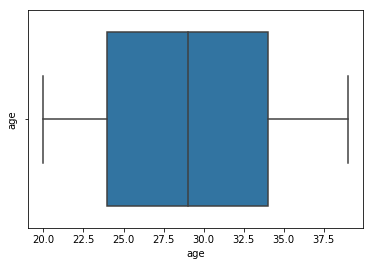

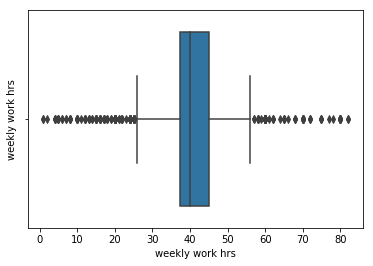

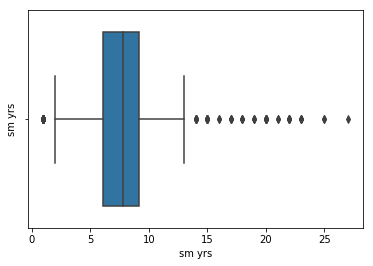

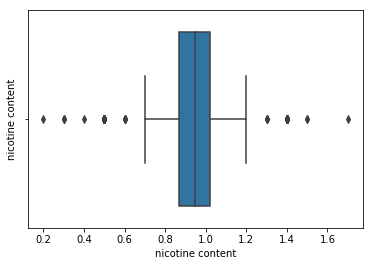

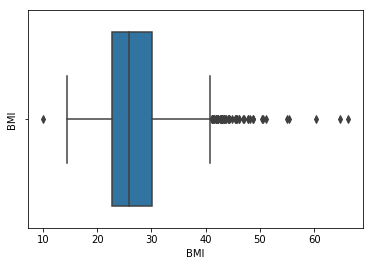

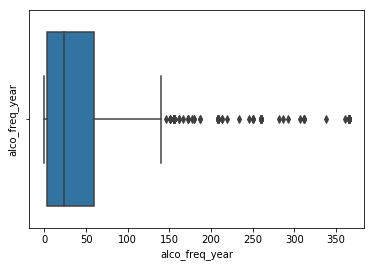

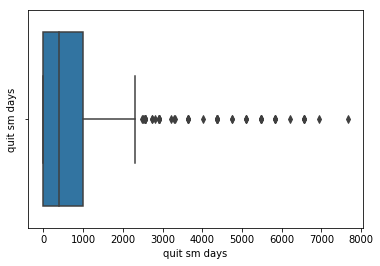

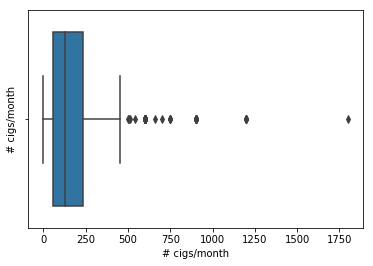

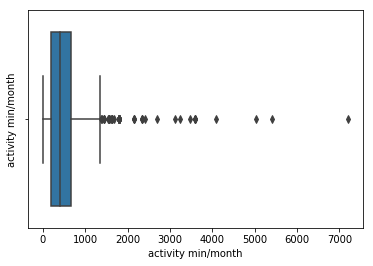

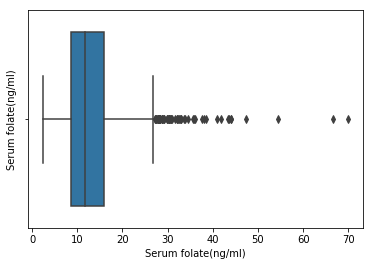

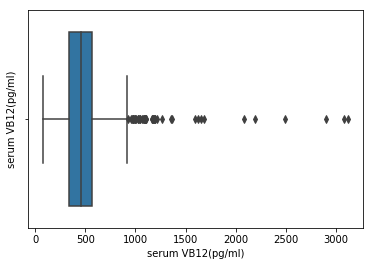

In [23]:
for numerical_variable in numerical_variables:
    sns.boxplot(x=df[numerical_variable])
    plt.ylabel(numerical_variable)
    plt.show()

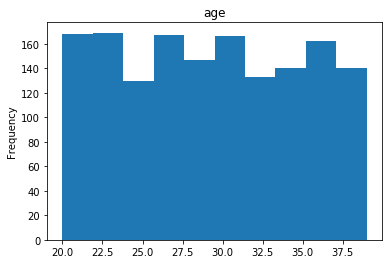

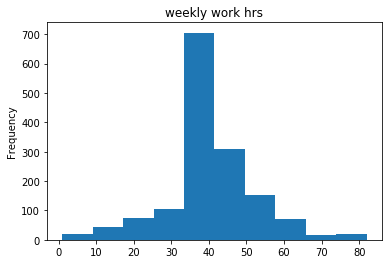

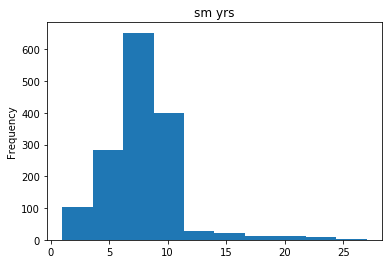

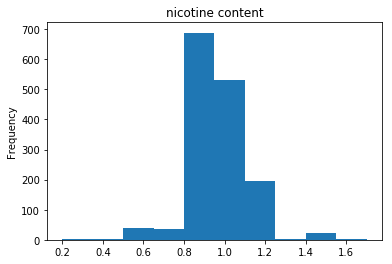

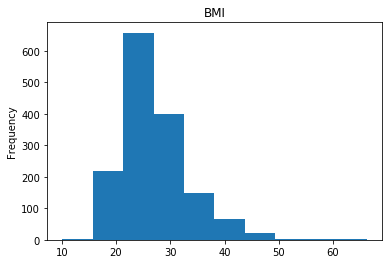

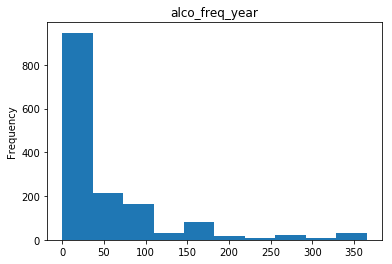

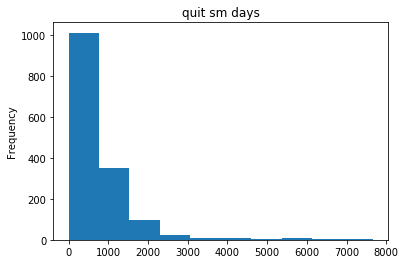

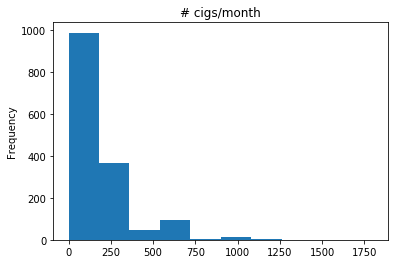

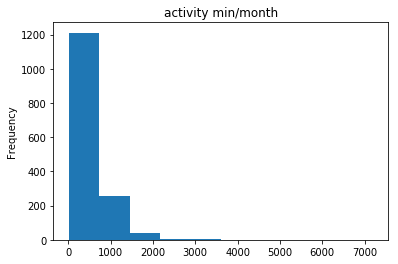

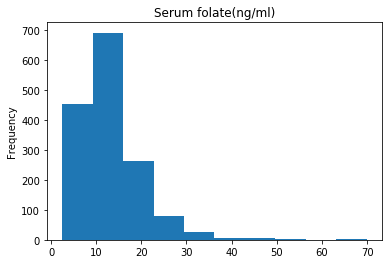

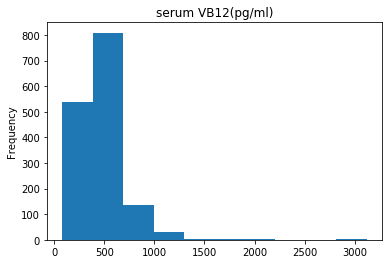

In [24]:
for num in numerical_variables:
    plt.figure()
    df[num].plot(kind='hist')
    plt.title(num)

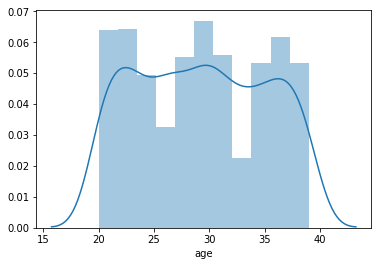

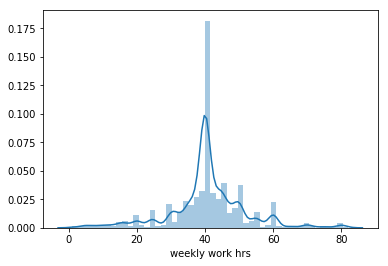

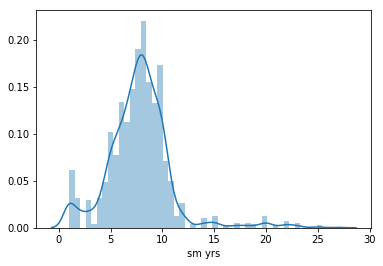

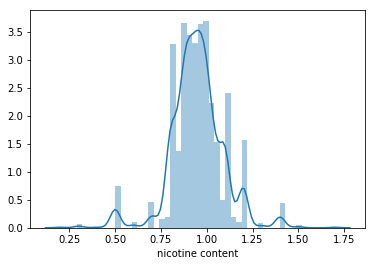

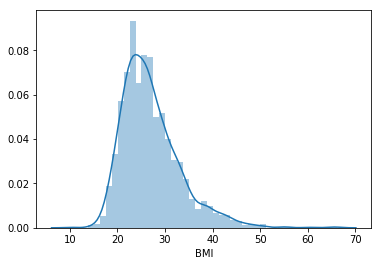

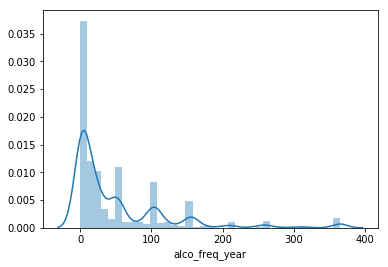

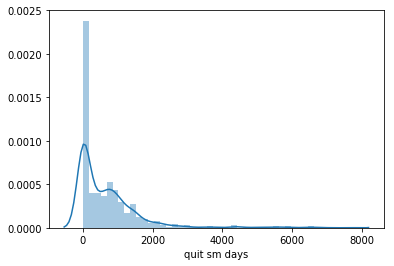

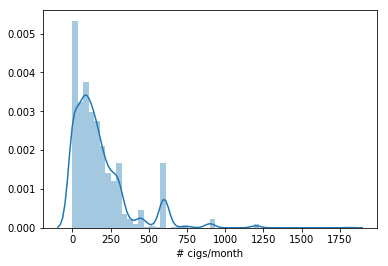

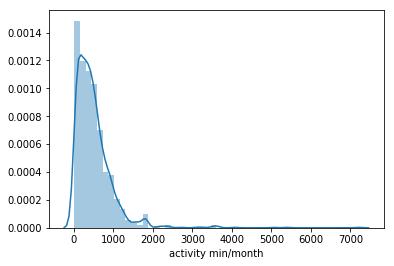

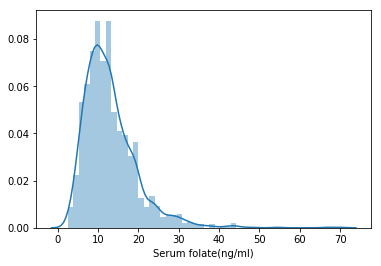

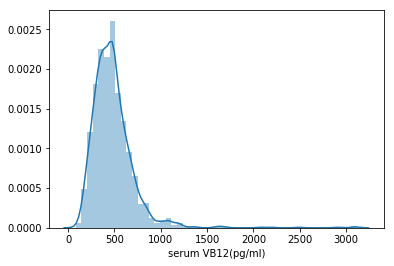

In [25]:
for num in numerical_variables:
    plt.figure()
    sns.distplot(df[num])

If skewness is less than -1 or greater than 1, the distribution is highly skewed.
If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

In [26]:
skew_degree = df[numerical_variables].skew().sort_values(ascending=False)
skew_degree

activity min/month     4.362246
serum VB12(pg/ml)      3.960368
quit sm days           3.022310
# cigs/month           2.327517
alco_freq_year         2.313641
Serum folate(ng/ml)    2.066976
sm yrs                 1.366353
BMI                    1.363362
age                    0.044579
weekly work hrs       -0.050937
nicotine content      -0.202315
dtype: float64

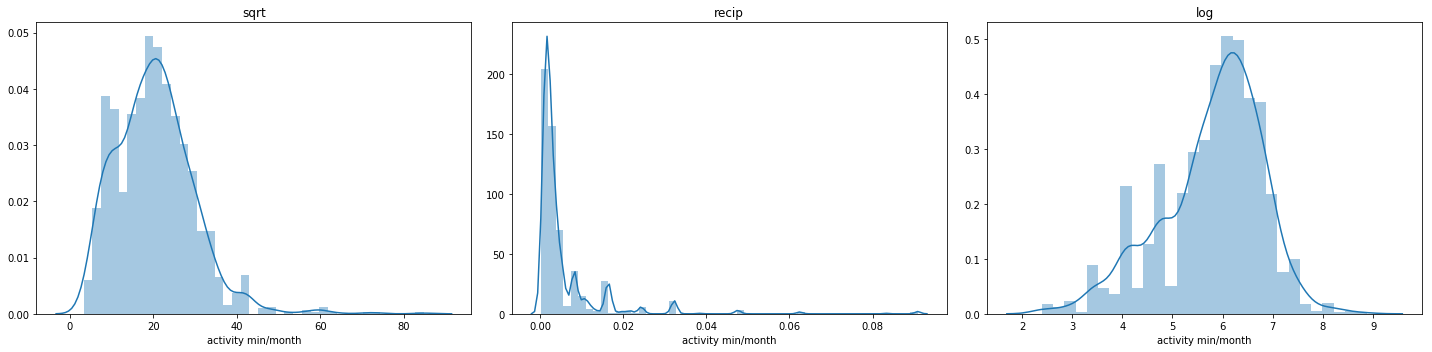

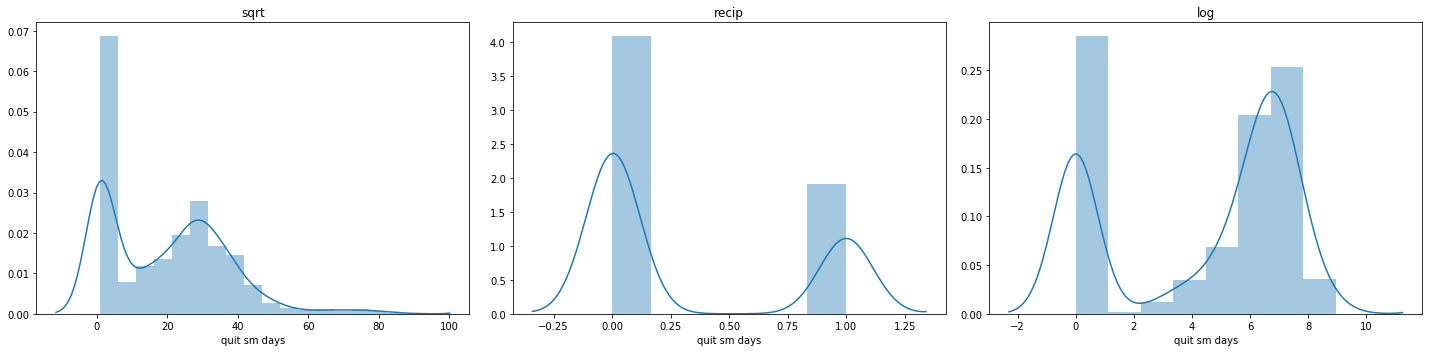

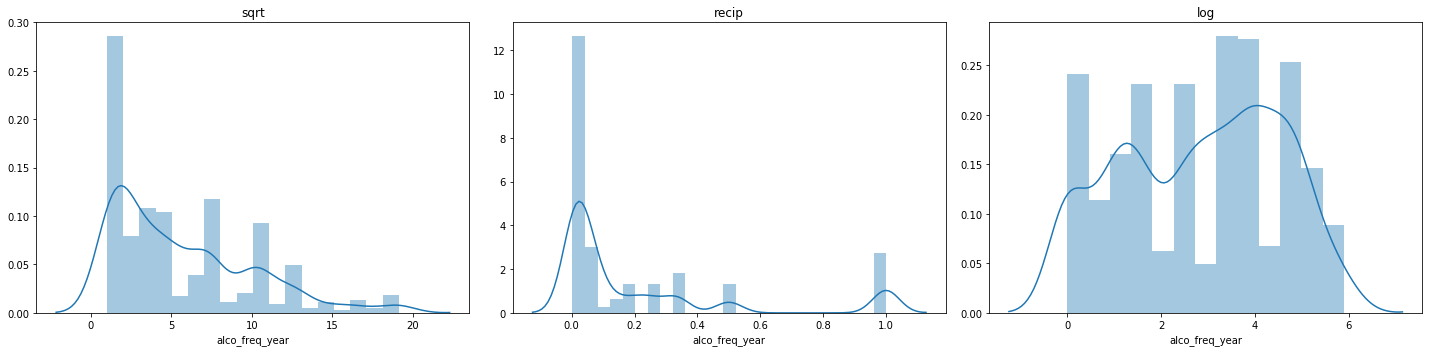

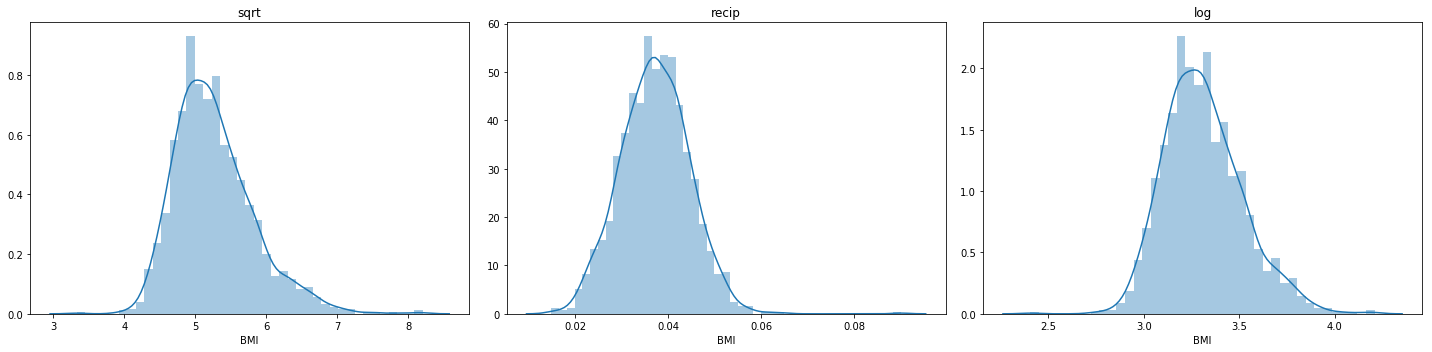

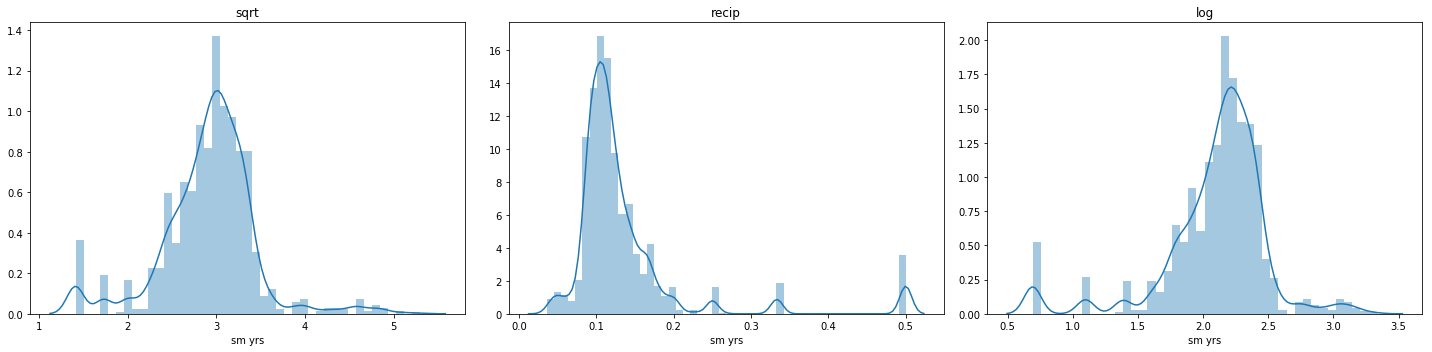

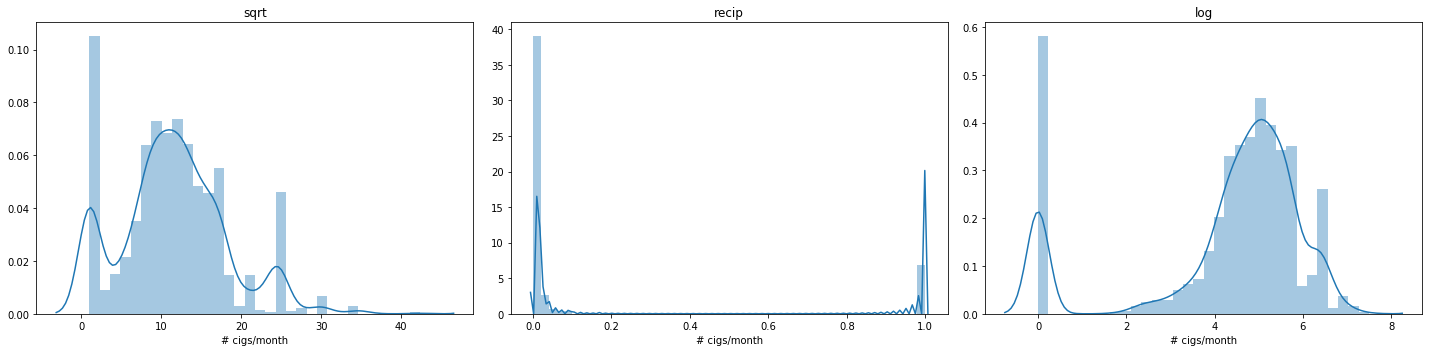

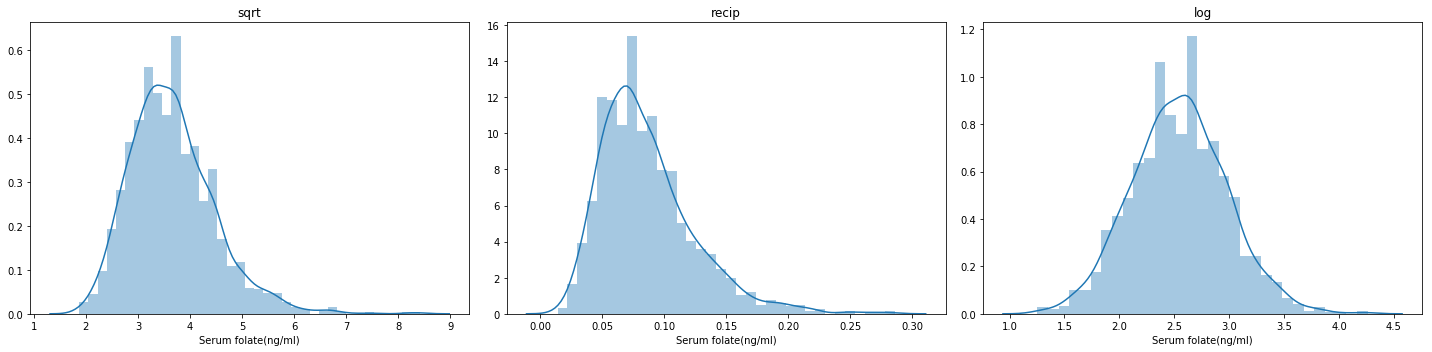

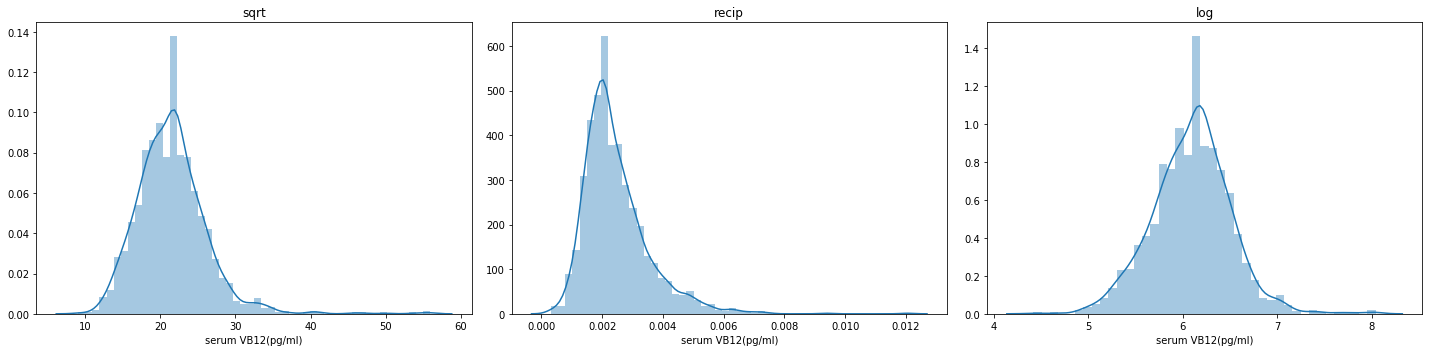

In [27]:
transform_nums = ['activity min/month','quit sm days','alco_freq_year','BMI','sm yrs','# cigs/month','Serum folate(ng/ml)','serum VB12(pg/ml)']
for tn in transform_nums:
    fig,(ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3,figsize=(20, 5))
    x = df[tn]
    sqrt_x = (x+1)**(0.5)
    recip = 1/(x+1)
    logx = np.log(x+1)
    sns.distplot(sqrt_x,ax=ax1).set_title('sqrt')
    sns.distplot(recip,ax=ax2).set_title('recip')
    sns.distplot(logx,ax=ax3).set_title('log')
    fig.tight_layout()


In [28]:
#log transform: 'activity min/month','BMI','Serum folate(ng/ml)','serum VB12(pg/ml)'
#sqrt:sm yrs
df['activity min/month'] = np.log(df['activity min/month']+1)
df['BMI'] = np.log(df['BMI'])
df['sm yrs'] = (df['sm yrs'])**(0.5)
df['quit sm days'] = np.log(df['quit sm days']+1)
df['alco_freq_year'] = np.log(df['alco_freq_year']+1)
df['# cigs/month'] = (df['# cigs/month'])**(0.5)
df['Serum folate(ng/ml)'] = np.log(df['Serum folate(ng/ml)']+1)
df['serum VB12(pg/ml)'] = np.log(df['serum VB12(pg/ml)']+1)


In [29]:
skew_degree = df[numerical_variables].skew().sort_values(ascending=False)
skew_degree

BMI                    0.500648
# cigs/month           0.336525
serum VB12(pg/ml)      0.150826
Serum folate(ng/ml)    0.132534
age                    0.044579
weekly work hrs       -0.050937
alco_freq_year        -0.155312
nicotine content      -0.202315
sm yrs                -0.289956
quit sm days          -0.528012
activity min/month    -0.652065
dtype: float64

Trees are not affected by scaling because the splitting criterion first orders the values of each feature and then calculate the gini\entropy of the split. Some scaling methods keep this order, so no change to the accuracy score. 

In [30]:
df[numerical_variables].head(20)

,age,weekly work hrs,sm yrs,nicotine content,BMI,alco_freq_year,quit sm days,# cigs/month,activity min/month,Serum folate(ng/ml),serum VB12(pg/ml)
SEQN,,,,,,,,,,,
12.0,37.0,53.0,2.607681,0.93,3.461044,3.218876,6.371612,10.899541,5.888878,3.178054,6.594413
20.0,23.0,40.1,3.098387,0.95,3.223958,5.056246,3.367296,0.000000,3.433987,3.039749,5.564520
34.0,38.0,48.9,2.000000,1.20,3.214324,3.970292,0.000000,12.247449,6.803505,2.240710,7.105786
66.0,37.0,55.0,2.828427,0.92,3.399539,0.000000,7.358831,5.019960,5.707110,2.572612,6.212606
69.0,27.0,20.0,2.846050,0.97,3.647230,4.653960,7.063904,7.745967,4.955827,1.945910,6.495266
81.0,30.0,43.2,2.898275,0.88,3.356684,3.970292,5.545177,11.298230,4.483003,2.219203,6.423247
97.0,32.0,60.0,2.880972,0.94,3.266439,0.000000,7.031741,0.000000,5.198497,2.640324,6.181495
107.0,30.0,58.0,2.626785,0.88,3.139073,1.098612,7.235619,8.763561,6.709304,2.727853,7.973500
120.0,30.0,50.0,2.428992,0.95,3.217043,0.000000,7.509883,0.000000,4.795791,2.388763,5.337538


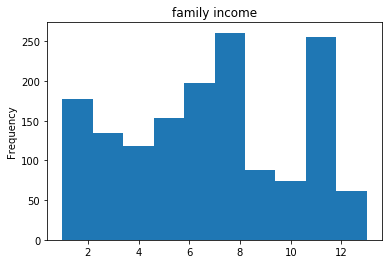

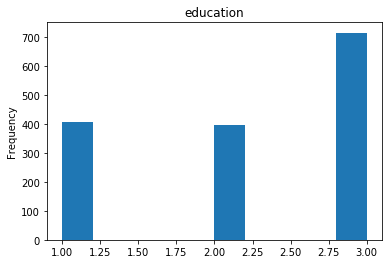

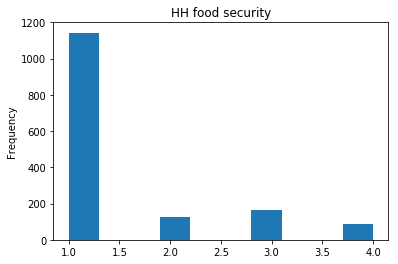

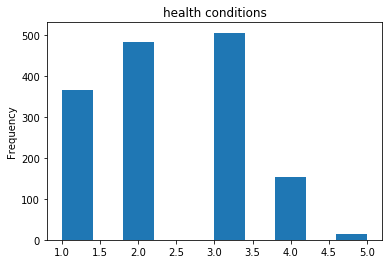

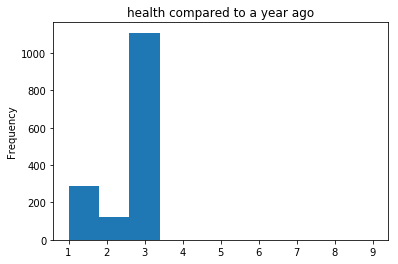

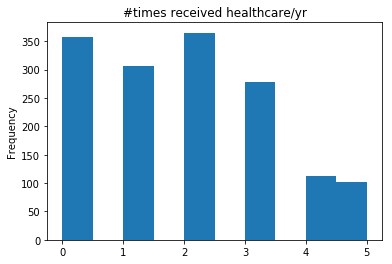

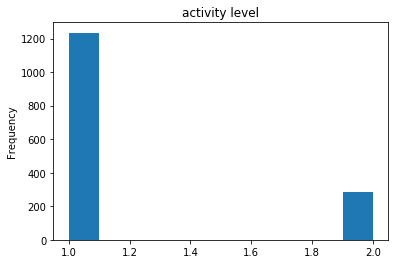

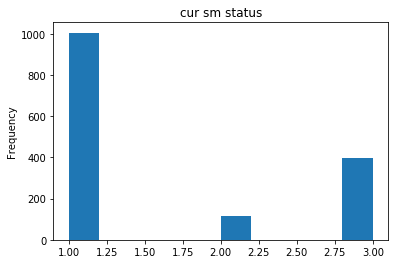

In [31]:
df[ordinal_variables].head(20)
for ordi in ordinal_variables:
    plt.figure()
    df[ordi].plot(kind='hist')
    plt.title(ordi)

# Feature selection

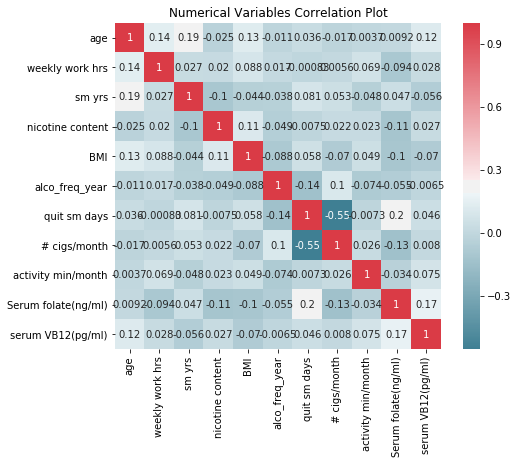

In [32]:
# pearson correlations can only be used to check for numerical variables
pearson_corr_heatmap()

* Select based on correlations (see above)
* Select based on p values. If the pvalue is above 0.05 then we remove the feature

In [33]:
# 待完成：sm是statsmodel里的，需要在sklearn里找pvalue相对应的部分

def Backward_Elimination():
    import statsmodels.api as sm

    feature_list = list(X_names)
    pmax = 1
    while (len(feature_list)>0):
        p= []
        X_1 = X[feature_list]
        X_1 = sm.add_constant(X_1)
        model = sm.clf(y,X_1).fit()
        p = pd.Series(model.pvalues.values[1:],index = feature_list)      
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>0.05):
            print('')
            feature_list.remove(feature_with_p_max)
        else:
            break
    selected_features_BE = feature_list
    print(selected_features_BE)

In [34]:
# https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
# wrapper method
def recursive_feature_elimination():
    l = len(X_names)
    feature_num_list=np.arange(1,l)            
    high_score=0
    feature_num=0 # optimal number of feature       
    score_list =[]
    for n in range(len(feature_num_list)):
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
        clf = LinearRegression()
        rfe = RFE(clf,feature_num_list[n])
        X_train_rfe = rfe.fit_transform(X_train,y_train)
        X_test_rfe = rfe.transform(X_test)
        clf.fit(X_train_rfe,y_train)
        score = clf.score(X_test_rfe,y_test)
        score_list.append(score)
        if(score>high_score):
            high_score = score
            feature_num = feature_num_list[n]
    print("Optimum number of features: %d" %feature_num)
    print("Accuracy with %d features: %f" % (feature_num, high_score))
    
    # feed optimal feature num into clf 
    cols = list(X_names)
    clf = LinearRegression()
    rfe = RFE(clf, feature_num)             
    X_rfe = rfe.fit_transform(X,y)  

    clf.fit(X_rfe,y)              
    temp = pd.Series(rfe.support_,index = cols)
    selected_features_rfe = temp[temp==True].index
    print(selected_features_rfe)

* regularization avoids overfitting
* work by penalizing the magnitude of coefficients of features along with minimizing the error between predicted and actual observations. 
* These are called ‘regularization’ techniques. 
* Ridge Regression:
    * Performs L2 regularization, i.e. adds penalty equivalent to square of the magnitude of coefficients 
    * Minimization objective = LS Obj + α * (sum of square of coefficients)
* Lasso Regression:
    * Performs L1 regularization, i.e. adds penalty equivalent to absolute value of the magnitude of coefficients
    * Minimization objective = LS Obj + α * (sum of absolute value of coefficients)
* Lasso method overcomes the disadvantage of Ridge regression by not only punishing high values of the coefficients β but actually setting them to zero if they are not relevant. Therefore, you might end up with fewer features included in the model than you started with, which is a huge advantage. Lasso Regression has the ability to nullify the impact of an irrelevant feature in the data, meaning that it can reduce the coefficient of a feature to zero thus completely eliminating it and hence is better at reducing the variance when the data consists of many insignificant features. Ridge regression, however, can not reduce the coefficients to absolute zero. Ridge regression performs better when the data consists of features which are sure to be more relevant and useful.
* lasso - linear model, benefit from scaling & normalization of input data

Alpha= 0.0003672598017314588
mse =  0.07233357246591461
Lasso picked 8 variables and eliminated the other 36 variables

Features to keep: 
['health conditions', 'visit to mental pro', 'Employment status', 'sm 100 cig?', 'pain (last yr)', '# cigs/month', 'female', 'Mexican American']

Features to remove: 
['age', 'family income', 'education', 'military', 'HH food security', 'health compared to a year ago', '#times received healthcare/yr', 'weekly work hrs', 'cur sm status', 'sm yrs', 'nicotine content', 'freq:12 drinks/yr?', 'ever use cocaine', 'activity level', 'Serum folate(ng/ml)', 'serum VB12(pg/ml)', 'diabetes status', 'prescr. medicine', 'BMI', 'weight goal realized', 'alco_freq_year', 'quit sm days', 'activity min/month', 'male', 'now married', 'was married', 'never married', 'non-family house', 'family house', 'home owned', 'rented home', 'home:other', 'Other Hispanic', 'Non-Hispanic White', 'Non-Hispanic Black', 'Other/Multi-racial']


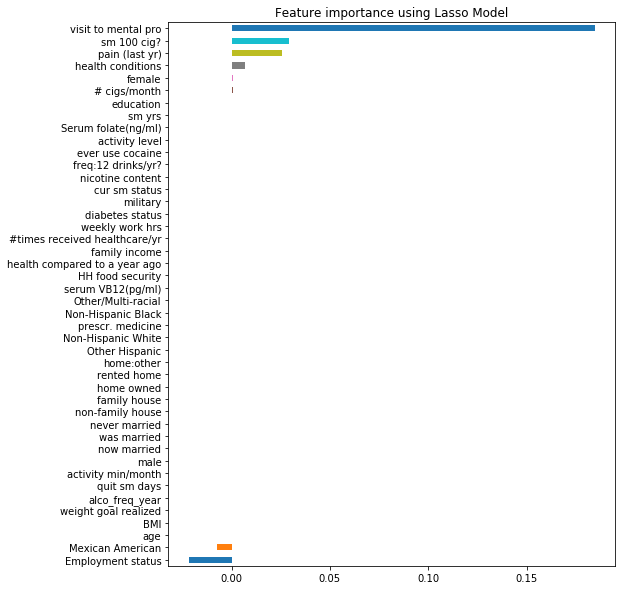

In [82]:
# embedded method
def lasso():
    X = df.drop('mental illness',1)
    y = df['mental illness']
    
#     reg = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
#     reg.fit(X, y)
#     coef = pd.Series(reg.coef_, index = X.columns)
#     imp_coef = coef.sort_values()
    
#     print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
#     print("Best score using built-in LassoCV: %f" %reg.score(X,y))
#     print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")   
#     print()
#     print('The eliminated features are:')
#     print(coef[reg.coef_==0])

    
    
    X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    lasso = Lasso(max_iter=10000, normalize=True)

    lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
    lassocv.fit(X_train, y_train)
    lasso.set_params(alpha=lassocv.alpha_)
    lasso.fit(X_train, y_train)
    coef = pd.Series(lasso.coef_, index=X.columns)
    
    print("Alpha=", lassocv.alpha_)
    print("mse = ",mean_squared_error(y_test, lasso.predict(X_test)))
    print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")   
    print()
    
    features_to_keep = []
    remove_list_lasso = []
    for name, coefficient in coef.items():
        if coefficient != 0:
            features_to_keep.append(name)
        else:
            remove_list_lasso.append(name)
            
    print('Features to keep: ')
    print(features_to_keep)
    print()
    print('Features to remove: ')
    print(remove_list_lasso)
    imp_coef = coef.sort_values()
    plt.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using Lasso Model")
    
lasso()

In [81]:
print('chi test remove:')
print(remove_list_chi)
print('corr with y remove:')
print(remove_list_corr.index)

chi test remove:
['was married', 'never married', 'non-family house', 'family house', 'Other Hispanic', 'Non-Hispanic Black', 'Other/Multi-racial', 'home owned', 'rented home', 'home:other']
corr with y remove:
Index(['age', 'weight goal realized', 'freq:12 drinks/yr?', 'cur sm status',
       'never married', 'military', 'male', 'female', 'HH food security',
       'rented home', 'home owned', 'Other/Multi-racial', 'Non-Hispanic Black',
       'nicotine content', 'sm yrs', 'Other Hispanic', 'activity min/month',
       'education', 'family income', 'BMI', 'Serum folate(ng/ml)',
       'diabetes status', 'serum VB12(pg/ml)', 'alco_freq_year',
       'weekly work hrs', 'activity level', 'home:other', 'non-family house',
       'family house'],
      dtype='object')


In [36]:
feature_target_correlation(correlation_coefficient)

mental illness                   1.000000
visit to mental pro              0.217413
health conditions                0.091504
sm 100 cig?                      0.086577
pain (last yr)                   0.086444
#times received healthcare/yr    0.083992
prescr. medicine                 0.081022
ever use cocaine                 0.080148
quit sm days                     0.079758
# cigs/month                     0.079301
Employment status                0.079078
Mexican American                 0.069671
now married                      0.069510
Non-Hispanic White               0.061677
health compared to a year ago    0.055125
was married                      0.051886
age                              0.047033
weight goal realized             0.044567
freq:12 drinks/yr?               0.041012
cur sm status                    0.040346
never married                    0.038453
military                         0.037932
female                           0.037722
male                             0

[3.881e+00 4.031e-01 8.128e-02 2.073e+00 1.126e+00 5.251e+00 1.192e+00
 6.660e+01 1.270e+01 2.614e+00 1.479e-01 6.709e+00 1.182e+00 9.265e-02
 1.794e-02 7.300e-01 7.843e+00 4.692e-03 1.569e-02 3.020e-03 1.101e-01
 7.914e+00 7.142e+00 3.033e-03 2.004e+00 7.186e-02 2.182e+01 4.045e+01
 4.539e-02 9.349e-01 1.231e+00 2.256e+00 3.575e+00 1.847e+00 1.693e-04
 1.133e-04 6.486e-01 7.530e-01 1.961e-02 5.364e+00 6.601e-01 3.268e+00
 7.379e-01 9.564e-01]
[('health compared to a year ago', 1.1919747722709788), ('male', 1.2308257260916513), ('never married', 1.846858107328739), ('weight goal realized', 2.0040961818203025), ('military', 2.073349579959328), ('now married', 2.2564082775598453), ('Employment status', 2.61392005517703), ('Non-Hispanic White', 3.267667485937206), ('was married', 3.5752482781421526), ('age', 3.88072799963552), ('health conditions', 5.251442776481855), ('Mexican American', 5.3637707631465235), ('sm 100 cig?', 6.708567113682288), ('prescr. medicine', 7.14225002194918), ('ev

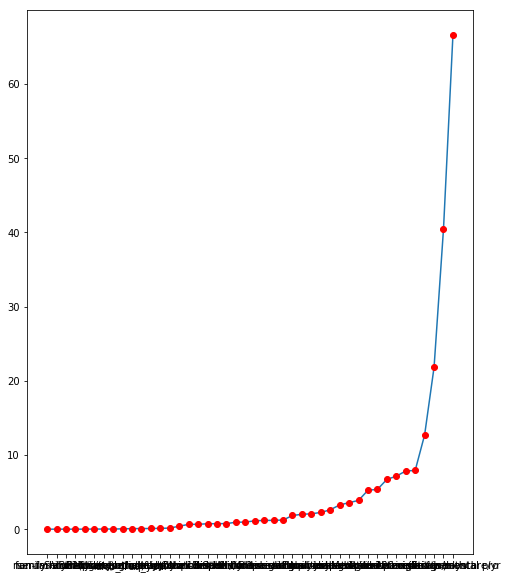

In [37]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
X = df.drop(['mental illness'],axis = 1).values
y = df['mental illness'].values
# feature extraction
test = SelectKBest(score_func=chi2, k=20)
fit = test.fit(X, y)
# summarize scores
set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
X_names = df.drop(['mental illness'],axis = 1).columns.tolist()
feature_scores = []
for name in X_names:
    i = X_names.index(name)
    score = fit.scores_[i]
    feature_scores.append((name,score))
def Sort_Tuple(tup):  
    tup.sort(key = lambda x: x[1])  
    return tup 
# 20 features with highest score using SelectKBest
print(Sort_Tuple(feature_scores)[24:]) 
x_val = [x[0] for x in feature_scores]
y_val = [x[1] for x in feature_scores]
plt.plot(x_val,y_val)
plt.plot(x_val,y_val,'or')
plt.show()

# Export

In [38]:
df.to_csv('Depression Project Part 2.csv',index=False,sep=',')